In [17]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
import os
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from tomography import coherent_state_tomography_copy as cst2
from visualization import state_visualization as state_vis
from quantum_utils import quantum_optics_utils as qou

from mpl_toolkits.mplot3d.axes3d import Axes3D
from math_utils import statistics_utils as su

In [18]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


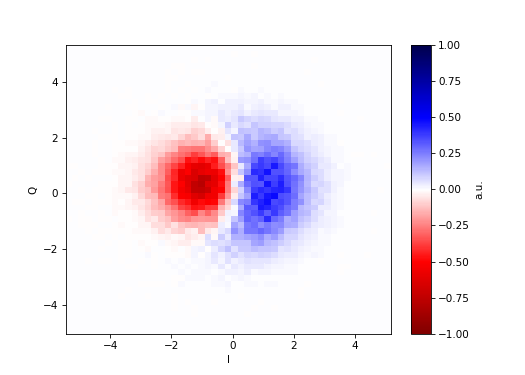

<IPython.core.display.Javascript object>


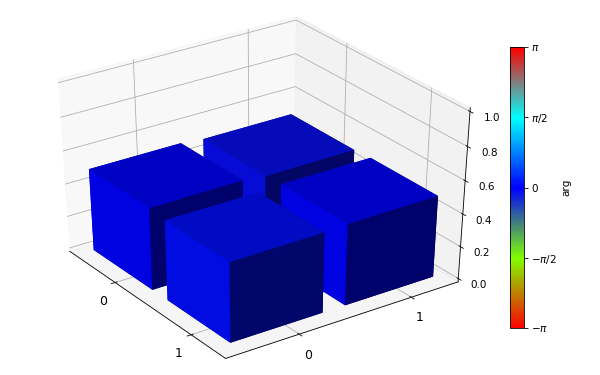

<IPython.core.display.Javascript object>


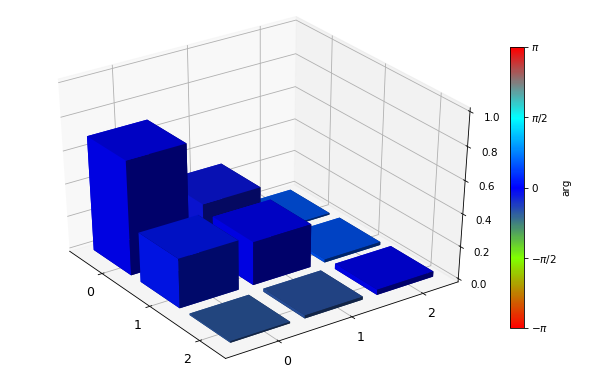

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.6996246 +0.j         0.30317167-0.0415351j  0.00818439+0.00510109j]
 [0.30317167+0.0415351j  0.26749773+0.j         0.01646436+0.00934555j]
 [0.00818439-0.00510109j 0.01646436-0.00934555j 0.03287768+0.j        ]]

In [26]:
pi = np.pi
scale = 1

path = "/Users/andreas/Desktop/work/cluster_state/photon_tomography/measurement_data/"
f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_real.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_imag.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_p1 = (data_real_all + 1j*data_imag_all)
shots_all_p1 = scale * shots_all_p1
f_real.close(); f_imag.close()

f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_real_dark.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_imag_dark.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_dark = (data_real_all + 1j*data_imag_all)
shots_all_dark = scale * shots_all_dark
f_real.close(); f_imag.close()

hist_2D_p1 = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), bins = 50, density = True)
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[hist_2D_p1[1][0], hist_2D_p1[1][-1]], [hist_2D_p1[2][0], hist_2D_p1[2][-1]]],
                                 bins = 50, density = True)
dI_dQ = (hist_2D_p1[1][0] - hist_2D_p1[1][-1])*(hist_2D_p1[2][0] - hist_2D_p1[2][-1])/2500

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
yy, xx = np.meshgrid(hist_2D_p1[1][:-1], hist_2D_p1[2][:-1])
pcolor = ax.pcolormesh(xx, yy, (hist_2D_p1[0] - hist_2D_dark[0])/dI_dQ, cmap='seismic_r')
fig.colorbar(pcolor, ax=ax, aspect = 15, label = "a.u.")
ax.set_xlabel('I'); ax.set_ylabel('Q') 
pcolor.set_clim(-1,1)


# LOSS SCALING, LOOK AT JUST 2x2 RHO FROM MOMENTS
a = np.mean(shots_all_p1); hdag_h = np.mean(np.abs(shots_all_dark)**2); 
hdag_2_h_2 = np.mean(np.abs(shots_all_dark)**4) 
adag_a = np.mean(np.abs(shots_all_p1)**2) - hdag_h
a_2 = np.mean(shots_all_p1**2); 
adag_2_a = np.mean(np.conj(shots_all_p1)*np.abs(shots_all_p1)**2) - 2 * np.conj(a) * hdag_h
adag_2_a_2 = np.mean(np.abs(shots_all_p1)**4) - 4*adag_a*hdag_h - hdag_2_h_2

loss_scaling = 0.67

rho = qutip.Qobj(np.array([[1 - adag_a, a], [np.conj(a), adag_a]]))
rho = (rho - (1- loss_scaling) * np.array([[1,0],[0,0]]))/loss_scaling


fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)
qutip.matrix_histogram_complex(rho, fig=fig, ax=ax) 
rho

rho_from_moments = np.zeros((3,3), dtype = complex)

rho_from_moments[0,0] = 1 - adag_a +  adag_2_a_2/2
rho_from_moments[0,1] = a - np.conj(adag_2_a)
rho_from_moments[0,2] = a_2/np.sqrt(2)

rho_from_moments[1,0] = np.conj(rho_from_moments[0,1])
rho_from_moments[1,1] = adag_a - adag_2_a_2
rho_from_moments[1,2] = np.conj(adag_2_a)/np.sqrt(2)


rho_from_moments[2,0] = np.conj(rho_from_moments[0,2])
rho_from_moments[2,1] = np.conj(rho_from_moments[1,2])
rho_from_moments[2,2] = adag_2_a_2/2

#rho_from_moments = (rho_from_moments - (1- loss_scaling) * np.array([[1,0,0],[0,0,0],[0,0,0]]))/loss_scaling
fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)
qutip.matrix_histogram_complex(qutip.Qobj(rho_from_moments).unit(), fig=fig, ax=ax) 
qutip.Qobj(rho_from_moments)

In [219]:
print(np.max(np.abs(shots_all_dark)))

5.435630425955035


In [5]:
max_x = 7.5
mesh_size = 0.1
number_of_noise_photons = 1.314

# Define the range of dimensions
dim = 300

noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

s = time.time()
noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                               noise_base=noise_state,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 4137.142413139343 seconds


<IPython.core.display.Javascript object>


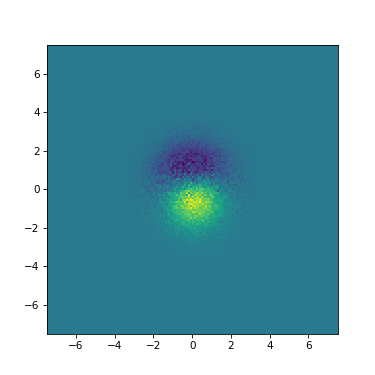

In [6]:
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

hist_2D = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]
fig, ax = plt.subplots(figsize=(5, 5))
ax.pcolormesh(xs, ps, hist_2D_dark - hist_2D)

<IPython.core.display.Javascript object>


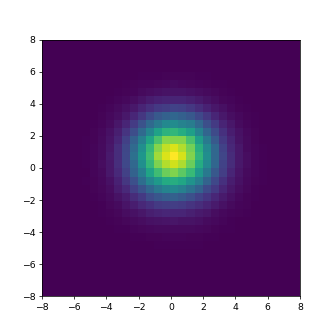

4.0


In [163]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.pcolormesh(xs, ps, hist_2D_dark)
print(np.sum(hist_2D_dark))

In [164]:
print(hist_2D_dark[0][0])

0.0


In [7]:
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 1000
s = time.time()
reconstructed_superposition_state, lls = \
    cst2.perform_coherent_state_MLE(
        noisy_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=1e-12,
        cutoff=1e-12,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')
# HERE

Time for MLE reconstruction for dim = 300: 15681.77277970314 s


In [9]:
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 2000
s = time.time()
reconstructed_superposition_state_2, lls_2 = \
    cst2.perform_coherent_state_MLE(
        noisy_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=1e-12,
        cutoff=1e-12,
        rho0=reconstructed_superposition_state_2,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')
# HERE

NameError: name 'reconstructed_superposition_state_2' is not defined

0.9998819817629149


<IPython.core.display.Javascript object>


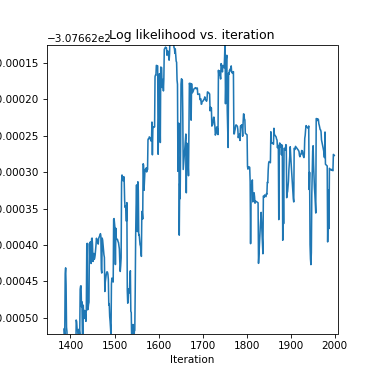

Text(0.5, 1.0, 'Log likelihood vs. iteration')

In [10]:
print(reconstructed_superposition_state.tr())
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(lls)), lls)
ax.set_ylabel('Log likelihood')
ax.set_xlabel('Iteration')
ax.set_title('Log likelihood vs. iteration')

<IPython.core.display.Javascript object>


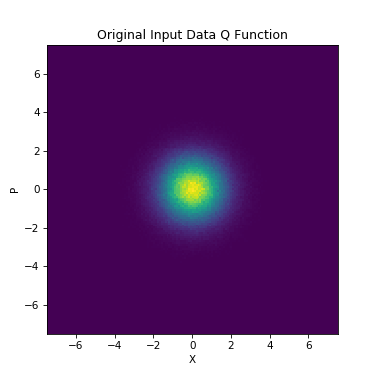

<IPython.core.display.Javascript object>


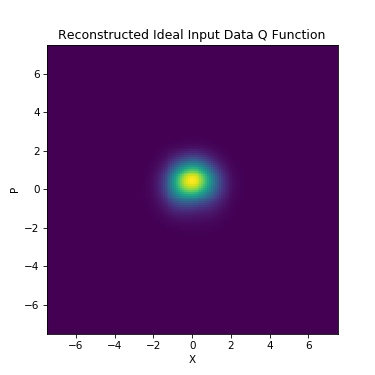

<IPython.core.display.Javascript object>


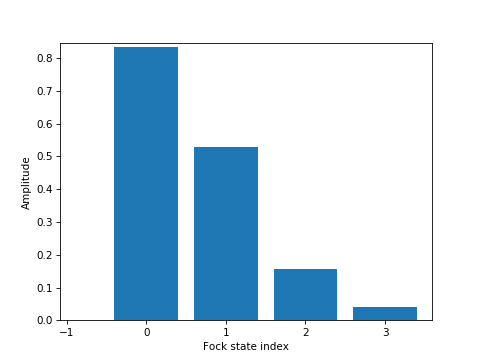

In [11]:
cst2.plot_coherent_state_tomography_Q_functions(hist_2D_dark,
                                               reconstructed_superposition_state,
                                               xs,
                                               ps)

<IPython.core.display.Javascript object>


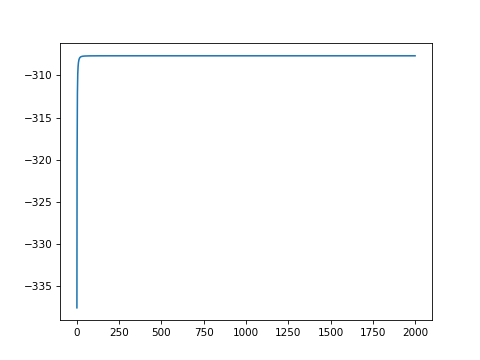

In [14]:
fig, ax = plt.subplots()
ax.plot(lls)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


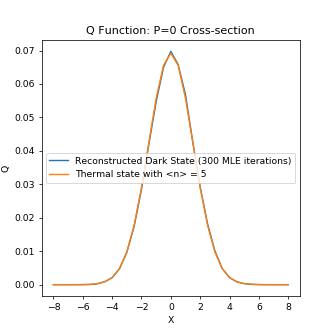

Trace distance: 0.026742490650404356


In [200]:
number_of_noise_photons = 3.6
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
# noisy_qfunc = qutip.qfunc(reconstructed_superposition_state, xs, ps, g=2)
noisy_qfunc = qutip.qfunc(noise_state, xs, ps, g=2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xs, hist_2D_dark[len(xs) // 2], label='Reconstructed Dark State (300 MLE iterations)')
ax.plot(xs, noisy_qfunc[len(xs) // 2], label='Thermal state with <n> = 5')
ax.set_xlabel('X')
ax.set_ylabel('Q')
ax.legend()
ax.set_title('Q Function: P=0 Cross-section')

print('Trace distance: ' + str(qutip.tracedist(noise_state, reconstructed_superposition_state)))

<IPython.core.display.Javascript object>


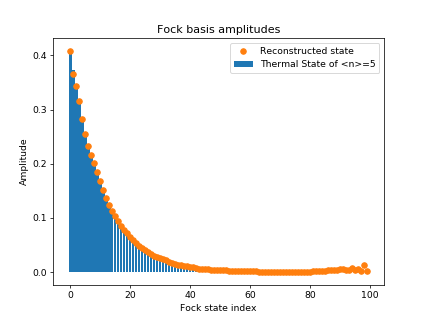

In [170]:
legend_labels = {'ref': 'Thermal State of <n>=5', 'data': 'Reconstructed state'}
state_vis.plot_fock_basis_amplitudes_with_reference(reconstructed_superposition_state,
                                                    noise_state,
                                                    legend_labels, 
                                                    title='Fock basis amplitudes')

In [231]:
dim = 300
max_x = 8.5
mesh_size = 0.5
number_of_noise_photons = 1.4

reconstructed_dark_state = reconstructed_superposition_state
noise_state = reconstructed_dark_state
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

s = time.time()
noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              noise_base=noise_state,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

hist_2D = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

Constructing POVM took: 192.9706470966339 seconds


In [233]:
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 1000
s = time.time()
reconstructed_dark_state, lls = \
    cst2.perform_coherent_state_MLE(
        noisy_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=1e-12,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

# STOPPED HERE 10:53 PM - 1/18/2021

Time for MLE reconstruction for dim = 300: 1013.7011308670044 s


33


../../utils/tomography/coherent_state_tomography_copy.py:315: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


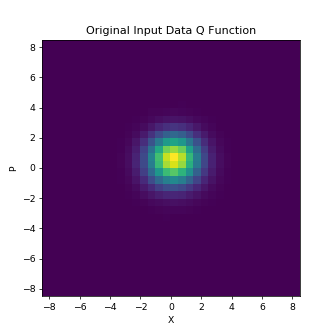

../../utils/tomography/coherent_state_tomography_copy.py:333: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


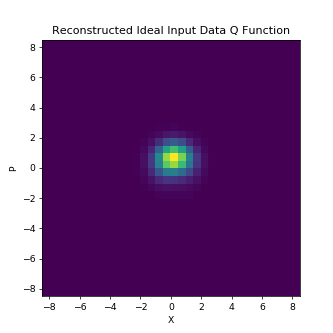

../../utils/visualization/state_visualization.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


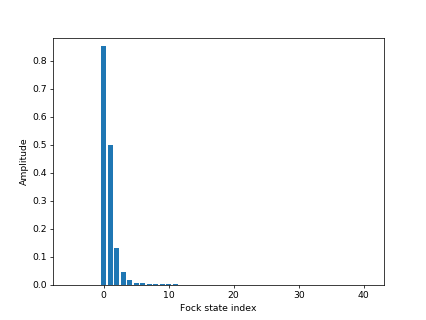

In [234]:
print(len(hist_2D_dark))
cst2.plot_coherent_state_tomography_Q_functions(hist_2D,
                                               reconstructed_dark_state,
                                               xs,
                                               ps)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


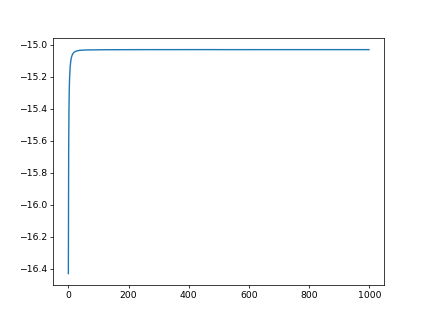

In [210]:
fig, ax = plt.subplots()
ax.plot(range(len(lls)), lls)

In [242]:
# 1000 + 1000 + 3000 + 9000 + 6000 + P20000

# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 6000
s = time.time()
reconstructed_dark_state_5, lls_5 = \
    cst2.perform_coherent_state_MLE(
        noisy_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=1e-12,
        identity_mixin=0,
        rho0=reconstructed_dark_state_4)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 300: 7207.679801225662 s


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


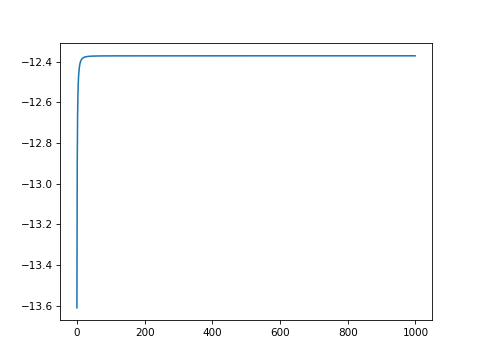

-12.370582518697315
-12.370575720198495
-12.370572075904963
-12.370577207705887
-12.370588207343925


In [277]:
fig, ax = plt.subplots()
ax.plot(range(len(lls)), lls)
print(np.max(lls))
print(np.max(lls_2))
print(np.max(lls_3))
print(np.max(lls_4))
print(np.max(lls_5))

33


../../utils/tomography/coherent_state_tomography_copy.py:315: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


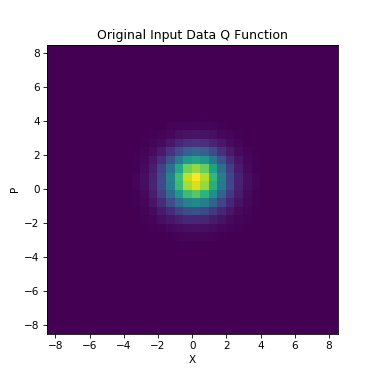

../../utils/tomography/coherent_state_tomography_copy.py:333: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, num_data_sets, figsize=(5*num_data_sets, 5))


<IPython.core.display.Javascript object>


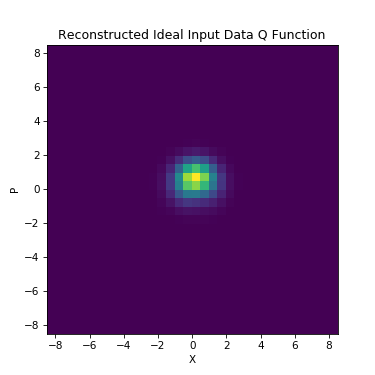

../../utils/visualization/state_visualization.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


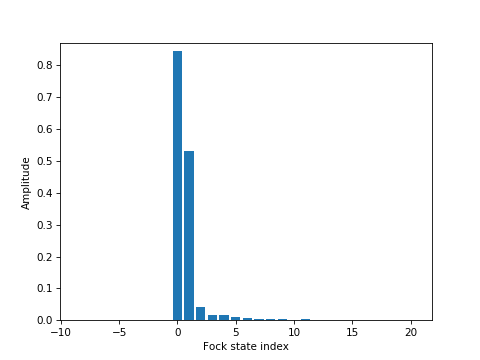

In [244]:
print(len(hist_2D_dark))
cst2.plot_coherent_state_tomography_Q_functions(hist_2D,
                                               reconstructed_dark_state_5,
                                               xs,
                                               ps)

In [12]:
state_vis.plot_fock_basis_amplitudes_with_reference(reconstructed_dark_state_5, reconstructed_dark_state_4, {'ref':'4', 'data':'5'})

NameError: name 'reconstructed_dark_state_5' is not defined

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


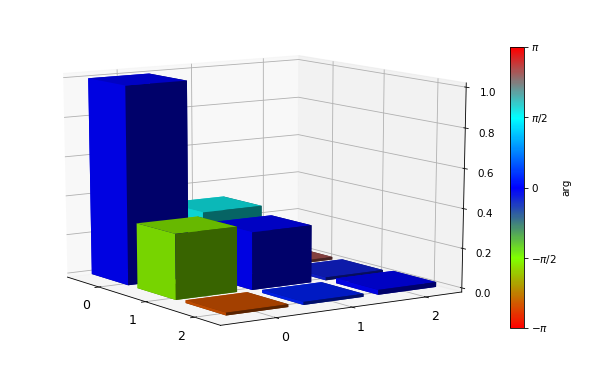

(<Figure size 800x500 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x1a2b8262d0>)

In [271]:
moments = qou.compute_matrix_of_moments(reconstructed_dark_state_5, 3)
fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)

qutip.matrix_histogram_complex(qutip.Qobj(moments), fig=fig, ax=ax) 

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


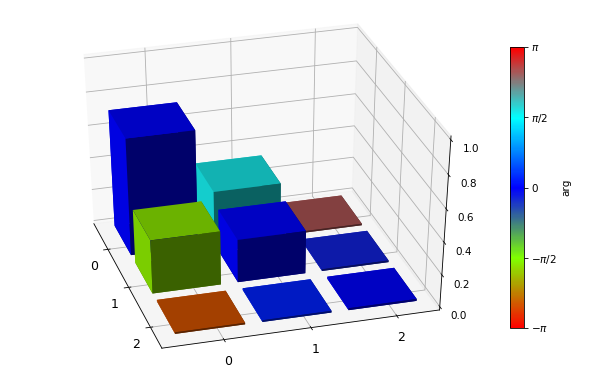

(0.7212769575119865+0j)
1.0000000000000002


In [265]:
rho_from_moments = np.zeros((3, 3), dtype=np.complex)

adag_a = moments[1][1]
a = moments[0][1]
a_2 = moments[0][2]
adag_2_a = moments[2][1]
adag_2_a_2 = moments[2][2]

rho_from_moments[0,0] = 1 - adag_a +  adag_2_a_2/2
rho_from_moments[0,1] = a - np.conj(adag_2_a)
rho_from_moments[0,2] = a_2/np.sqrt(2)

rho_from_moments[1,0] = np.conj(rho_from_moments[0,1])
rho_from_moments[1,1] = adag_a - adag_2_a_2
rho_from_moments[1,2] = np.conj(adag_2_a)/np.sqrt(2)


rho_from_moments[2,0] = np.conj(rho_from_moments[0,2])
rho_from_moments[2,1] = np.conj(rho_from_moments[1,2])
rho_from_moments[2,2] = adag_2_a_2/2

fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)

qutip.matrix_histogram_complex(qutip.Qobj(rho_from_moments), fig=fig, ax=ax) 

print(rho_from_moments[0][0])
print(qutip.Qobj(rho_from_moments).tr())

<IPython.core.display.Javascript object>


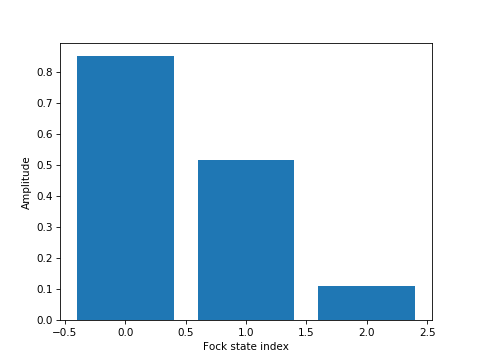

In [267]:
state_vis.plot_fock_basis_amplitudes(qutip.Qobj(rho_from_moments))

In [ ]:
print(len(hist_2D_dark))
cst2.plot_coherent_state_tomography_Q_functions(hist_2D,
                                               reconstructed_dark_state_3,
                                               xs,
                                               ps)

In [15]:
state_vis.plot_fock_basis_amplitudes(qutip.Qobj(rho_from_moments))

NameError: name 'rho_from_moments' is not defined

<IPython.core.display.Javascript object>


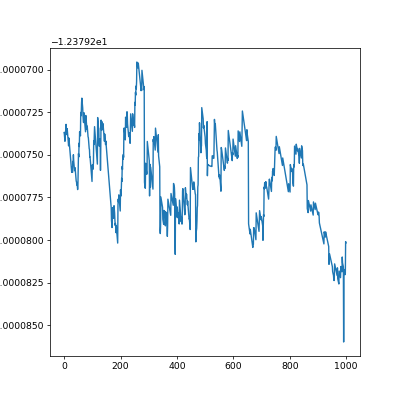

In [183]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(range(len(lls)), lls)

In [184]:
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 1000
s = time.time()
reconstructed_dark_state_3, lls_3 = \
    cst2.perform_coherent_state_MLE(
        noisy_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=1e-10,
        identity_mixin=0,
        rho0=reconstructed_dark_state_2)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 300: 683.1191620826721 s


3


<IPython.core.display.Javascript object>


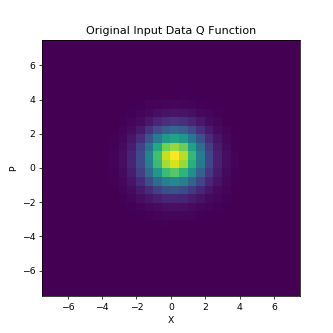

<IPython.core.display.Javascript object>


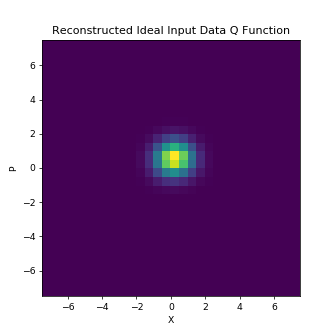

<IPython.core.display.Javascript object>


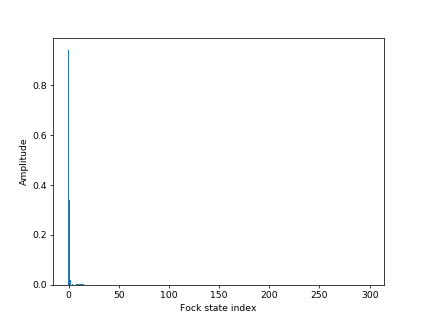

../../utils/visualization/state_visualization.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


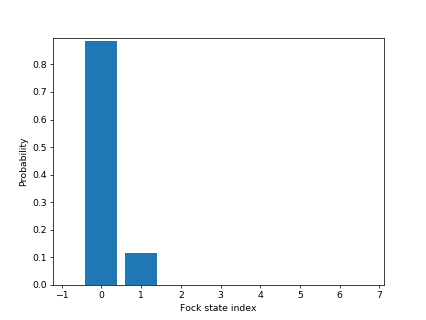

In [186]:
print(len(hist_2D_dark))
cst2.plot_coherent_state_tomography_Q_functions(hist_2D,
                                               reconstructed_dark_state_3,
                                               xs,
                                               ps)
state_vis.plot_fock_basis_probabilities(reconstructed_dark_state_3)